<a href="https://colab.research.google.com/github/logikon-ai/logikon/blob/main/examples/quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logikon `/\/`** – Quickstart

*Analyzing and Evaluating LLM Reasoning Traces*

This notebook demonstrates the basic usage of the `logikon` package.

We're using 🤗's lightweight `zephyr-7b-beta` in this demo for its speed and small footprint. It tends to produce argumentative analyses that are creative and eloquent, rather than rigorous and exact -- and may hence not be the optimal expert model for your use cases.

> ⚠️ **Important notice.**
>
> **Logikon `/\/`** is in early development stage:
> * the package is subject to change at any time;
> * results can vary due to changes in methods, pipelines, or underlying models;
> * current speed and quality of evaluation results are not representative of future product.


**Table of contents**

1. [Set-up](#set-up)
2. [Get reasoning traces](#examples)
3. [Configure analysis](#configuration)
4. [Run analysis](#run)
5. [Inspect results](#inspect)

## 1. Set-up environment <a name="set-up"></a>

In [ ]:
# Please make sure that the following files from the `examples` folder
# in the `logikon-ai/logikon` GitHub repo are available.
!test -f "requirements.txt" || echo "Missing requirements.txt"
!test -f "setup.sh" || echo "Missing setup.sh"
!test -f "scoring.py" || echo "Missing scoring.py"

In [ ]:
# Configure the environment
import os

os.environ["LGK_FRAMEWORK"] = "llamacpp"
os.environ["LGK_DEVICE"] = "gpu"
os.environ["LGK_HUBREPO"] = "TheBloke/zephyr-7B-beta-GGUF"
os.environ["LGK_MODELWEIGHTS"] = "zephyr-7b-beta.Q6_K.gguf"
os.environ["LGK_TOKENIZER"] = "HuggingFaceH4/zephyr-7b-beta"
os.environ["LGK_RELEASE"] = "main"

In [ ]:
# Check gpu available
! [ "$LGK_DEVICE" = "gpu" ] && nvidia-smi

Fri Nov 10 08:34:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sh setup.sh

In [ ]:
import os

if os.environ.get("LGK_MODELWEIGHTS"):
  abspath = os.path.join(
    os.path.abspath("./models"),
    os.environ.get("LGK_MODELWEIGHTS")
  )
else:
  abspath = ""
os.environ["LGK_ABSPATH_MODELWEIGHTS"] = abspath
os.environ["LGK_ABSPATH_MODELWEIGHTS"]

'/content/models/zephyr-7b-beta.Q6_K.gguf'

In [ ]:
# Check whether model weights file is available
!test -f "$LGK_ABSPATH_MODELWEIGHTS" || echo "Cannot find model weights"

## 2. Example reasoning traces <a name="examples"></a>

In [ ]:
EXAMPLE = {
  "prompt": """Can you give me some advice on whether I should use Vim or Emacs?""",
  "completion": """
The choice between Vim and Emacs is a classic debate in the world of text editors and integrated
development environments (IDEs). Both Vim and Emacs are powerful and highly customizable, but they
have different philosophies and approaches to text editing. Your choice should depend on your
specific needs and preferences. Here's a careful analysis of both editors:

Vim:

Modal Editing: Vim uses a modal editing approach, which means it has different modes for different
tasks (insert mode, normal mode, visual mode, etc.). This can be more efficient for many users once
they become proficient, as it minimizes the need for extensive keyboard shortcuts.

Lightweight: Vim is known for its minimalistic design and lightweight footprint. It can run
efficiently on even older hardware and over SSH connections, making it an excellent choice for
remote server editing.

Highly Efficient for Editing: Once you've mastered Vim, it can be incredibly efficient for text
editing and code navigation. Vim users often rave about its speed and precision.

Emacs:

Extensible: Emacs is known for its extensibility. It's not just a text editor; it's an extensible
platform that can be turned into a full-fledged IDE or customized for any purpose. If you like the
idea of a highly customized environment, Emacs is a strong contender.

Moderate Learning Curve: Emacs has a learning curve, but it may be perceived as less steep than Vim's
for some users. The keybindings are more traditional, and it offers a range of graphical menus that
can help beginners.

Resource Intensive: Emacs can be more resource-intensive compared to Vim. It may not be the best
choice for extremely resource-constrained environments.""",
}

In [ ]:
import pandas as pd
df_traces = pd.DataFrame([EXAMPLE])
df_traces.head()

,prompt,completion
0,Can you give me some advice on whether I shoul...,\nThe choice between Vim and Emacs is a classi...


In [ ]:
# Save reasoning traces to file
df_traces.to_json("reasoning_traces.jsonl", orient="records", lines=True)

In [ ]:
# Check data file available
!head -2 "reasoning_traces.jsonl"

{"prompt":"Can you give me some advice on whether I should use Vim or Emacs?","completion":"\nThe choice between Vim and Emacs is a classic debate in the world of text editors and integrated\ndevelopment environments (IDEs). Both Vim and Emacs are powerful and highly customizable, but they\nhave different philosophies and approaches to text editing. Your choice should depend on your\nspecific needs and preferences. Here's a careful analysis of both editors:\n\nVim:\n\nModal Editing: Vim uses a modal editing approach, which means it has different modes for different\ntasks (insert mode, normal mode, visual mode, etc.). This can be more efficient for many users once\nthey become proficient, as it minimizes the need for extensive keyboard shortcuts.\n\nLightweight: Vim is known for its minimalistic design and lightweight footprint. It can run\nefficiently on even older hardware and over SSH connections, making it an excellent choice for\nremote server editing.\n\nHighly Efficient for Edit

## 3. Configure metrics, artifacts, and evaluation methods <a name="configuration"></a>

In [ ]:
config_dict = {
    # metrics to calculate
    "metrics": ["argmap_size", "n_root_nodes", "global_balance"],
    # artifacts to generate
    "artifacts": ["svg_argmap", "html_sunburst"],
    "global_kwargs": {
        "expert_model": os.environ["LGK_ABSPATH_MODELWEIGHTS"],
        "expert_model_kwargs": {
            "n_ctx": 3072,
            # comment out line below if no gpu
            "n_gpu_layers": -1,
            "tokenizer": os.environ["LGK_TOKENIZER"],
            # custom prompt template, make sure this fits the expert_model
            "prompt_template": {
                "sys_start": "\n<|system|>\n",
                "sys_end": "",
                "user_start": "\n<|user|>\n",
                "user_end": "",
                "ass_start": "\n<|assistant|>\n",
                "ass_end": "",
            },
        },
        "generation_kwargs": {"max_len": 3072},
        "llm_framework": "llama.cpp",
    },
}

In [ ]:
import yaml
with open('config.yml', 'w') as outfile:
    yaml.dump(config_dict, outfile, default_flow_style=False)

In [ ]:
# Check config file available
!head -10 "config.yml"

artifacts:
- svg_argmap
- html_sunburst
global_kwargs:
  expert_model: /content/models/zephyr-7b-beta.Q6_K.gguf
  expert_model_kwargs:
    n_ctx: 3072
    n_gpu_layers: -1
    prompt_template:
      ass_end: ''


## 4. Run analysis <a name="run"></a>

In [ ]:
# We'll use the following script to analyze the reasoning traces
!python scoring.py --help

usage: scoring.py [-h] [--config-file CONFIG_FILE] [--artifacts ARTIFACTS [ARTIFACTS ...]]
                  [--metrics METRICS [METRICS ...]] [--expert-model-path EXPERT_MODEL_PATH]
                  [--expert-tokenizer EXPERT_TOKENIZER] [--endpoint ENDPOINT]
                  [--use-cuda | --no-use-cuda] [--load-in-8bit | --no-load-in-8bit]
                  [--low-cpu-mem-usage | --no-low-cpu-mem-usage] [--n-ctx N_CTX]
                  [--n-gpu-layers N_GPU_LAYERS] [--llm-framework {transformers,llama.cpp}]
                  [--prompt-template PROMPT_TEMPLATE] [--generation-max-len GENERATION_MAX_LEN]
                  --reasoning-traces-file REASONING_TRACES_FILE [--output-dir OUTPUT_DIR]
                  [--output-file OUTPUT_FILE]

Score reasoning traces with logikon module.

options:
  -h, --help            show this help message and exit
  --config-file CONFIG_FILE
                        Path to yaml config file.
  --artifacts ARTIFACTS [ARTIFACTS ...]
                      

In [ ]:
# 🫖 This will take some time ... you may monitor `scoring.log`
!python scoring.py \
  --config-file config.yml \
  --reasoning-traces-file reasoning_traces.jsonl

0it [00:00, ?it/s]/usr/bin/dot
[Loading llama.cpp model from llama.cpp:/content/models/zephyr-7b-beta.Q6_K.gguf  with  {'n_ctx': 3072, 'n_gpu_layers': -1} ]
2023-11-10 11:20:14.372239: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 11:20:14.372304: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 11:20:14.372341: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 11:20:16.214637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

Reason-root edges:   0% 0/3 [00:00<?, ?it/s]
Reason-root edges:  33% 1/3 [00:19<

## 5. Inspect metrics and artifacts <a name="inspect"></a>

In [ ]:
df_scores = pd.read_json("outputs/reasoning_traces-scores.jsonl", lines=True)

In [ ]:
# Display metric scores
df_scores[config_dict.get("metrics",[])]

,argmap_size,n_root_nodes,global_balance
0,16,3,0.280143


In [ ]:
# Display sunburst at row index `idx`
idx=0

from IPython.display import HTML, display
assert idx<len(df_scores)

html = df_scores.iloc[idx].get("html_sunburst")
display(HTML(html))

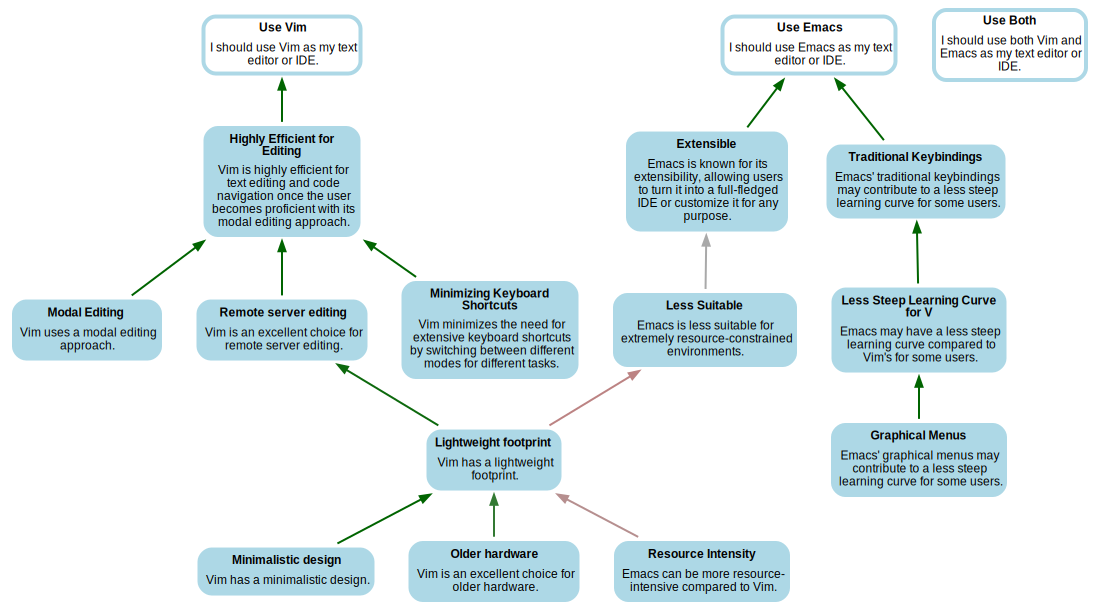

In [ ]:
# Display argument map at row index `idx`
idx=0

from IPython.display import SVG, display
assert idx<len(df_scores)

svg = df_scores.iloc[idx].get("svg_argmap")
style = "<style>svg{width:100% !important;height:100% !important;</style>"
display(HTML(style))
display(SVG(data=svg))

****

(c) 2023 The Logikon AI Team | License: Apache 2.0